In [1]:
import pandas as pd

In [2]:
url = "https://docs.google.com/spreadsheets/d/1vFWwNJ7-61O_QYaPo8d7bmw7K192az4R/export"
data_excel = pd.read_excel(url, sheet_name=0, header=9)
data_excel = data_excel.iloc[:, :-11]

In [3]:
#Obtengo las columnas que me interesan
#data = data.iloc[:, -10:]
col_sexo = data_excel.iloc[:, 0]
col_baremos = data_excel.iloc[:, -11:]

data  = pd.concat( [col_sexo, col_baremos], axis=1 )
data.head()

,Sexo,Somatización,Obsesión/com,Sen. Emocio.,Depresión,Ansiedad,Hostilidad,Ans. Fóbica,Ideación Paran.,Psicoticismo,Agotamiento,SA45
0,1,Promedio,Alto,Bajo,Promedio,Promedio,Promedio,Bajo,Bajo,Promedio,Bajo,Bajo
1,1,Alto,Promedio,Bajo,Alto,Promedio,Bajo,Promedio,Alto,Bajo,Bajo,Bajo
2,1,Bajo,Promedio,Promedio,Bajo,Bajo,Promedio,Bajo,Alto,Bajo,Alto,Bajo
3,1,Alto,Alto,Alto,Alto,Alto,Alto,Promedio,Alto,Bajo,Alto,Promedio
4,1,Promedio,Bajo,Alto,Alto,Promedio,Bajo,Alto,Alto,Bajo,Bajo,Bajo


In [4]:
#Creo el map
category_map = {
    'Bajo': 0,
    'Promedio': 1,
    'Alto': 2
}

In [5]:
#Convierto las categorias a numeros
data2 = data.copy()
for i in range(11):
    data2.iloc[:, 1+i ] = data2.iloc[:, 1+i ].map(category_map)

data2.head()

,Sexo,Somatización,Obsesión/com,Sen. Emocio.,Depresión,Ansiedad,Hostilidad,Ans. Fóbica,Ideación Paran.,Psicoticismo,Agotamiento,SA45
0,1,1,2,0,1,1,1,0,0,1,0,0
1,1,2,1,0,2,1,0,1,2,0,0,0
2,1,0,1,1,0,0,1,0,2,0,2,0
3,1,2,2,2,2,2,2,1,2,0,2,1
4,1,1,0,2,2,1,0,2,2,0,0,0


In [6]:
#Importo Pycaret para clasificacion
from pycaret.classification import *

In [7]:
clf = setup(data2, target='Agotamiento', session_id=123, fold=4)

,Description,Value
0,Session id,123
1,Target,Agotamiento
2,Target type,Multiclass
3,Original data shape,"(372, 12)"
4,Transformed data shape,"(372, 32)"
5,Transformed train set shape,"(260, 32)"
6,Transformed test set shape,"(112, 32)"
7,Numeric features,1
8,Categorical features,10
9,Preprocess,True


In [8]:
ridge = create_model('ridge', verbose=False)
lda = create_model('lda', verbose=False)
lr = create_model('lr', verbose=False)

In [9]:
lightgbm = create_model('lightgbm', verbose=False)
rf = create_model('rf', verbose=False)
knn = create_model('knn', verbose=False)

In [10]:
stacked_model = stack_models([ridge, lda, lr, lightgbm, rf, knn], meta_model=create_model('lr', verbose=False))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6462,0.0000,0.6462,0.6538,0.6488,0.4438,0.4445
1,0.7231,0.0000,0.7231,0.7298,0.7237,0.5623,0.5638
2,0.5385,0.0000,0.5385,0.5385,0.5354,0.2873,0.2890
3,0.7231,0.0000,0.7231,0.7426,0.7013,0.5541,0.5877
Mean,0.6577,0.0000,0.6577,0.6662,0.6523,0.4619,0.4712
Std,0.0757,0.0000,0.0757,0.0812,0.0728,0.1111,0.1184


In [11]:
# Evaluar el modelo apilado
predict_model(stacked_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.5893,0.7790,0.5893,0.5816,0.5836,0.3537,0.3551


,Sexo,Somatización,Obsesión/com,Sen. Emocio.,Depresión,Ansiedad,Hostilidad,Ans. Fóbica,Ideación Paran.,Psicoticismo,SA45,Agotamiento,prediction_label,prediction_score
129,1,2,1,2,1,2,2,1,2,2,1,1,1,0.6083
169,1,2,2,1,2,2,1,2,1,2,2,2,2,0.8447
234,1,2,2,2,2,2,1,2,2,2,2,2,2,0.8284
342,2,2,0,1,2,2,2,2,2,2,2,1,2,0.8343
289,2,2,2,2,2,2,2,2,2,2,2,2,2,0.7828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,1,1,1,2,1,1,2,2,2,2,1,1,1,0.6627
230,1,0,0,2,2,1,2,1,2,2,1,0,1,0.5436
115,1,2,1,0,0,0,1,0,0,0,0,0,1,0.4912
266,2,2,2,2,2,2,2,1,2,2,2,2,2,0.7550


In [12]:
# Finalizar el modelo
final_stacked_model = finalize_model(stacked_model)

# Predicción con todo el dataset
predictions = predict_model(final_stacked_model, data=data2)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7769,0.9103,0.7769,0.7757,0.7749,0.6492,0.6506


,Sexo,Somatización,Obsesión/com,Sen. Emocio.,Depresión,Ansiedad,Hostilidad,Ans. Fóbica,Ideación Paran.,Psicoticismo,SA45,Agotamiento,prediction_label,prediction_score
0,1,1,2,0,1,1,1,0,0,1,0,0,1,0.4102
1,1,2,1,0,2,1,0,1,2,0,0,0,1,0.5328
2,1,0,1,1,0,0,1,0,2,0,0,2,0,0.3931
3,1,2,2,2,2,2,2,1,2,0,1,2,2,0.5713
4,1,1,0,2,2,1,0,2,2,0,0,0,0,0.5800


In [17]:
evaluate_model(final_stacked_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

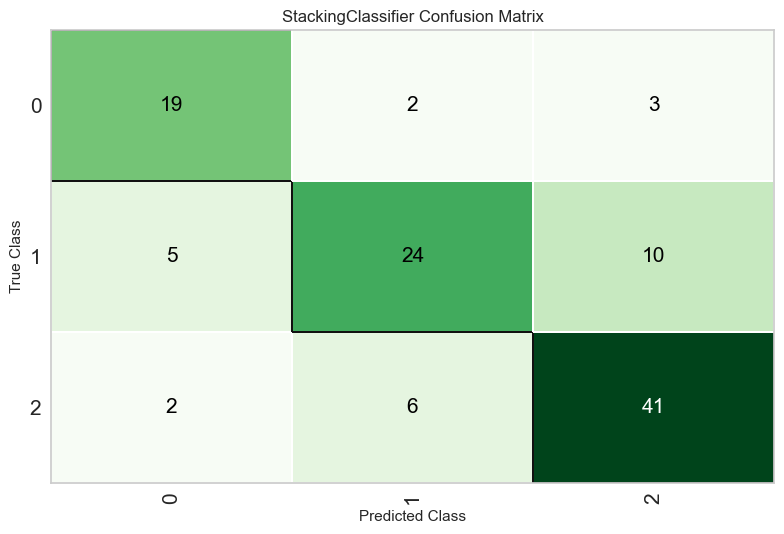

In [14]:
plot_model(final_stacked_model, plot='confusion_matrix')

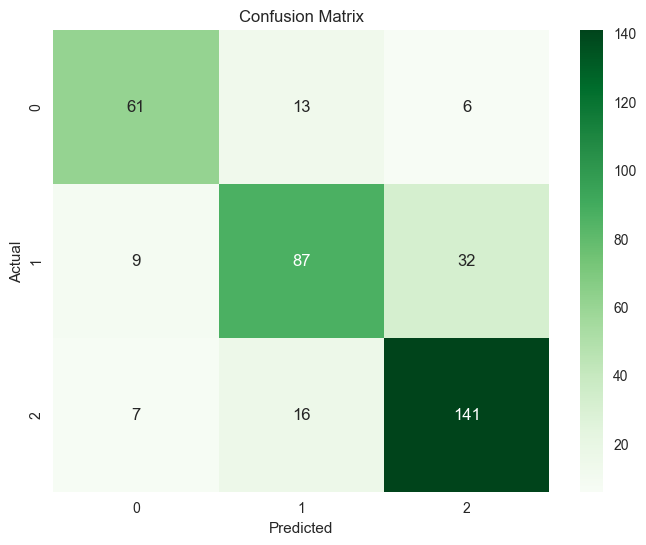

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las etiquetas reales y predichas
y_true = data2['Agotamiento'].astype(int)  # Reemplaza 'target_column' con el nombre de la columna objetivo
y_pred = predictions['prediction_label'].astype(int)   # PyCaret genera la columna 'Label' con las predicciones

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=final_stacked_model.classes_, yticklabels=final_stacked_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [16]:
from pycaret.classification import save_model

# Guardar el modelo entrenado
save_model(final_stacked_model, 'modelo-SA45-ECE_Sexo_SA45-total_stacked')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['Sexo'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Somatización', 'Obsesión/com',
                                              'Sen....
                                                                       p=2,
                                                         